<a href="https://colab.research.google.com/github/Danrangi/Diabetes-Doctor/blob/main/train_wmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# Step 1: Install required packages (optional, usually available)
!pip install pandas numpy matplotlib scikit-learn

# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
from google.colab import files








df = pd.read_csv('/content/drive/MyDrive/Dataset/diabetes.csv')
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [39]:
# Step 1: Check data types and overview
print("Data Overview:\n")
print(df.info())
print("\nStatistical Summary:\n")
print(df.describe())

# Step 2: Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Step 3: Split features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Step 4: Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Split into train, validation, and test sets
from sklearn.model_selection import train_test_split

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Second split: from 80%, take 60% train and 20% val (25% of 80%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Final shape check
print(f"\nTraining set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Data Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Statistical Summary:

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.10546

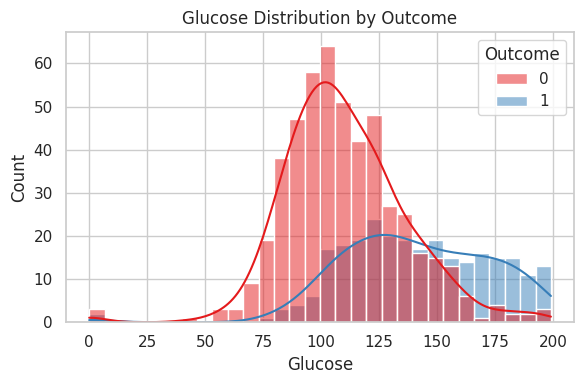

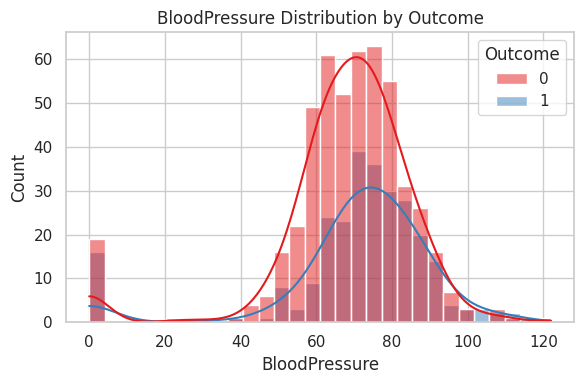

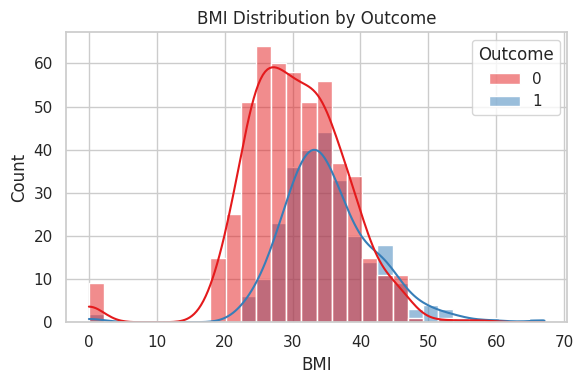

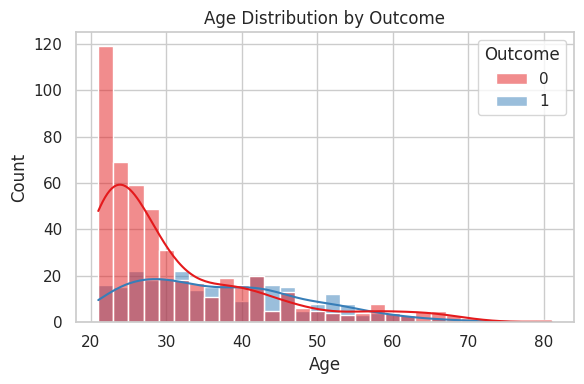

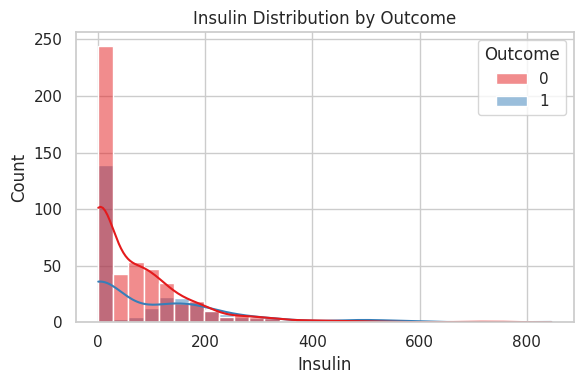

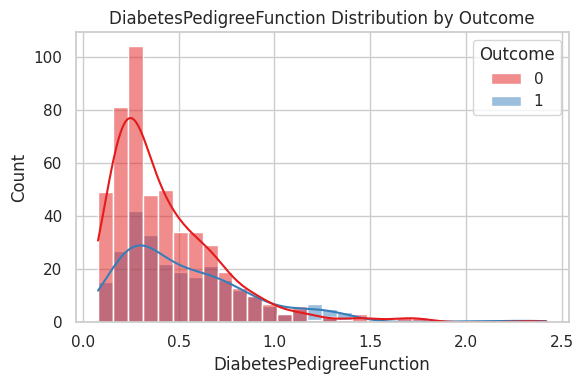

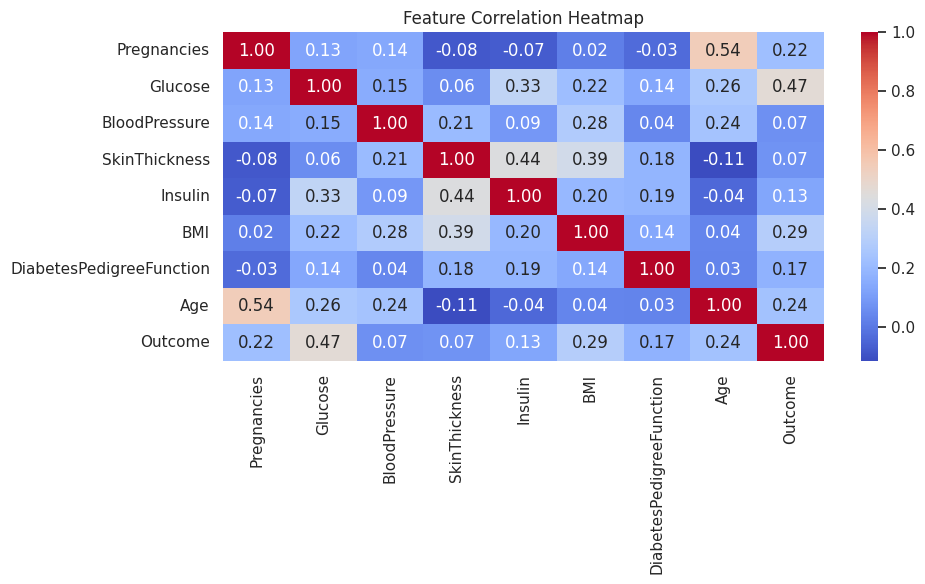

In [41]:
# Set style for seaborn
sns.set(style="whitegrid")

# Plot distribution of features grouped by Outcome
features = ['Glucose', 'BloodPressure', 'BMI', 'Age', 'Insulin', 'DiabetesPedigreeFunction']

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature, hue='Outcome', kde=True, palette='Set1', bins=30)
    plt.title(f'{feature} Distribution by Outcome')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


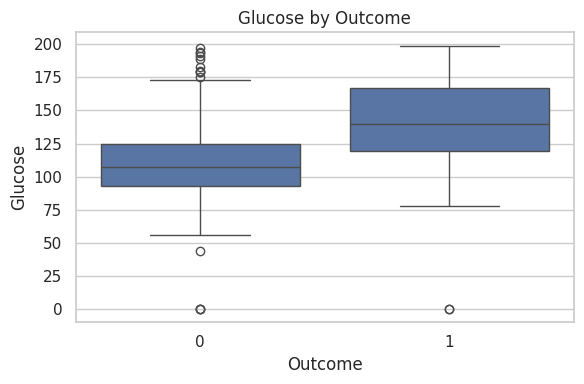

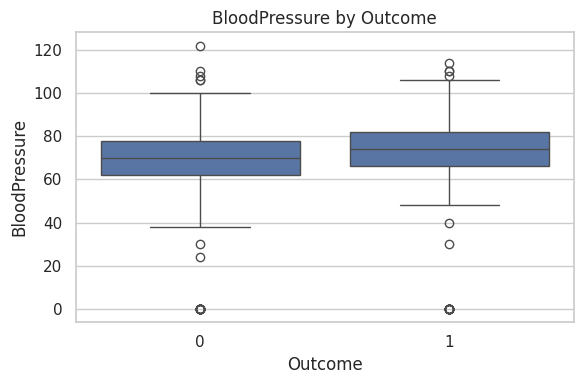

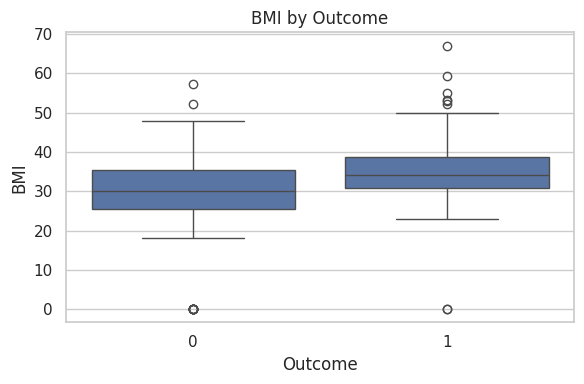

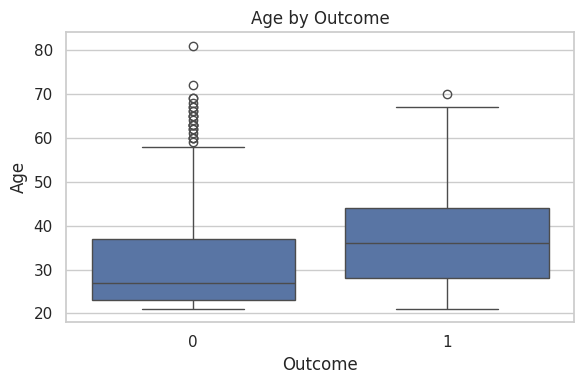

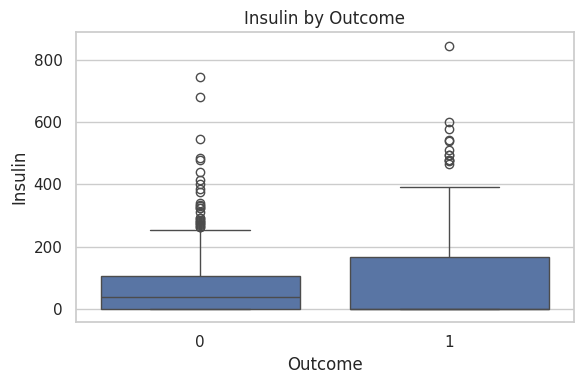

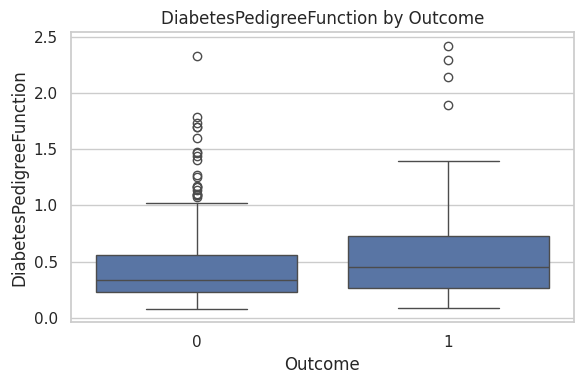

In [42]:
# Boxplots to check for outliers in key features
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Outcome', y=feature, data=df)
    plt.title(f'{feature} by Outcome')
    plt.tight_layout()
    plt.show()


In [44]:
# Initialize base classifiers
clf1 = LogisticRegression()
clf2 = SVC(probability=True)  # Enable probability for SVM
clf3 = RandomForestClassifier()

# Fit all classifiers on training data
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)

# Predict on validation data
pred1 = clf1.predict(X_val)
pred2 = clf2.predict(X_val)
pred3 = clf3.predict(X_val)

# Evaluate accuracies
acc1 = accuracy_score(y_val, pred1)
acc2 = accuracy_score(y_val, pred2)
acc3 = accuracy_score(y_val, pred3)

print(f"Logistic Regression Accuracy: {acc1:.4f}")
print(f"SVM Accuracy: {acc2:.4f}")
print(f"Random Forest Accuracy: {acc3:.4f}")


Logistic Regression Accuracy: 0.7792
SVM Accuracy: 0.7273
Random Forest Accuracy: 0.7468


In [46]:
# Step 1: Get probabilities from classifiers
prob1 = clf1.predict_proba(X_val)[:, 1]
prob2 = clf2.predict_proba(X_val)[:, 1]
prob3 = clf3.predict_proba(X_val)[:, 1]

# Step 2: Stack them
all_probs = np.vstack([prob1, prob2, prob3]).T  # Shape: (num_samples, num_classifiers)

# Step 3: Use validation accuracies as weights
weights = np.array([acc1, acc2, acc3])
weights = weights / weights.sum()  # Normalize to sum = 1

# Step 4: Define WMC prediction function
def weighted_median_prediction(probs, weights):
    final_preds = []
    for row in probs:
        # Sort predictions and weights by prediction value
        sorted_indices = np.argsort(row)
        sorted_preds = row[sorted_indices]
        sorted_weights = weights[sorted_indices]

        # Compute cumulative weights
        cum_weights = np.cumsum(sorted_weights)

        # Find where cumulative weight exceeds 0.5
        median_idx = np.where(cum_weights >= 0.5)[0][0]
        final_pred = 1 if sorted_preds[median_idx] >= 0.5 else 0
        final_preds.append(final_pred)

    return np.array(final_preds)

# Step 5: Predict using WMC
wmc_preds = weighted_median_prediction(all_probs, weights)

# Step 6: Evaluate WMC
from sklearn.metrics import classification_report, accuracy_score

print("\n Weighted Median Classifier Evaluation:")
print(f"WMC Accuracy: {accuracy_score(y_val, wmc_preds):.4f}")
print(classification_report(y_val, wmc_preds))



 Weighted Median Classifier Evaluation:
WMC Accuracy: 0.7597
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       101
           1       0.75      0.45      0.56        53

    accuracy                           0.76       154
   macro avg       0.76      0.69      0.70       154
weighted avg       0.76      0.76      0.74       154



In [47]:
# Step 1: Get test set probabilities
test_prob1 = clf1.predict_proba(X_test)[:, 1]
test_prob2 = clf2.predict_proba(X_test)[:, 1]
test_prob3 = clf3.predict_proba(X_test)[:, 1]

# Step 2: Stack them
test_probs = np.vstack([test_prob1, test_prob2, test_prob3]).T

# Step 3: Predict using WMC
test_preds = weighted_median_prediction(test_probs, weights)

# Step 4: Evaluate WMC on test set
print("\n Final WMC Performance on Test Set:")
from sklearn.metrics import accuracy_score, classification_report
print(f"WMC Test Accuracy: {accuracy_score(y_test, test_preds):.4f}")
print(classification_report(y_test, test_preds))



 Final WMC Performance on Test Set:
WMC Test Accuracy: 0.7338
              precision    recall  f1-score   support

           0       0.78      0.81      0.80        99
           1       0.63      0.60      0.62        55

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.71       154
weighted avg       0.73      0.73      0.73       154



In [49]:
# Save base models
joblib.dump(clf1, 'logistic_model.pkl')
joblib.dump(clf2, 'svm_model.pkl')
joblib.dump(clf3, 'rf_model.pkl')

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

# Save weights as a numpy array
np.save('model_weights.npy', weights)


In [ ]:
files.download('logistic_model.pkl')
files.download('svm_model.pkl')
files.download('rf_model.pkl')
files.download('scaler.pkl')
files.download('model_weights.npy')